In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pickle

from utils.util import read_yaml
from box import Box

from utils.eda_tools import select_good_period, single_column_vis
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [23]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [24]:
df_path = cfg.path.processed_data
df = pd.read_csv(df_path, parse_dates=['Date'], index_col=0)

In [25]:
df.shape

(26032, 59)

In [26]:
tag_list = list(df.columns)[5:-1]
len(tag_list)

53

In [27]:
# Create a dictionary to map the category to each tag
tag_df = pd.read_excel(cfg.path.tags_info)
# delete the first 3 str characters in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x[3:])
# convert the . into - in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x.replace('.', '-'))

tag_dict = dict(zip(tag_df['Tag'], tag_df['Category']))
print(tag_dict)

{'OXO-5FI635C Augusta': 'Measurement', 'OXO-5FI661A Augusta': 'Measurement', 'OXO-5FI696 Augusta': 'Independent', 'OXO-5FIC132 Augusta': 'Independent', 'OXO-5FIC600 Augusta': 'Target', 'OXO-5FIC601 Augusta': 'Target', 'OXO-5FIC602 Augusta': 'Control', 'OXO-5FIC603 Augusta': 'Control', 'OXO-5FIC606A Augusta': 'Control', 'OXO-5FIC606C Augusta': 'Control', 'OXO-5FIC607 Augusta': 'Control', 'OXO-5FIC609A Augusta': 'Target', 'OXO-5FIC609B Augusta': 'Control', 'OXO-5FIC611A Augusta': 'Control', 'OXO-5FIC611B Augusta': 'Control', 'OXO-5FIC612A Augusta': 'Target', 'OXO-5FIC612B Augusta': 'Target', 'OXO-5FIC618A Augusta': 'Control', 'OXO-5FIC618B Augusta': 'Control', 'OXO-5FIC618C Augusta': 'Control', 'OXO-5FIC618D Augusta': 'Control', 'OXO-5FIC622A Augusta': 'Control', 'OXO-5FIC622B Augusta': 'Control', 'OXO-5FIC622C Augusta': 'Control', 'OXO-5FIC636A Augusta': 'Control', 'OXO-5FIC636B Augusta': 'Control', 'OXO-5FIC636C Augusta': 'Control', 'OXO-5FQI691B Augusta': 'Measurement', 'OXO-5LI633B A

In [28]:
# find tag in tag_list which has Control value in tag_dict
ctrl_tag = [tag for tag in tag_list if tag_dict[tag] == 'Control']
print(len(ctrl_tag))
# the rest of the tags are independent tags
ind_tag = [tag for tag in tag_list if tag_dict[tag] != 'Control']
len(ind_tag)

29


24

### Split Live Data

In [29]:
# df = df.iloc[:, 5:-1]

In [30]:
df.shape

(26032, 59)

In [31]:
# split and the keep the last 10% as live data
df, live_df = train_test_split(df, test_size=0.1, shuffle=False)
df.shape, live_df.shape

((23428, 59), (2604, 59))

### Trained on Shuffled Data

In [32]:
X = df[ctrl_tag+ind_tag]
y = df[cfg.kpi1.tag1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
# split the data into train, validation and test set by 8:1:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [33]:
X_train.shape, X_test.shape, X_val.shape

((18742, 53), (2343, 53), (2343, 53))

In [34]:
# my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)

In [35]:
import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define the objective function to be optimized
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
    }

    # Create and train the XGBRegressor with the specified hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-07-20 15:19:34,039] A new study created in memory with name: no-name-7b439ee5-cf2a-4ed4-b186-050627819a10
[I 2023-07-20 15:20:01,940] Trial 0 finished with value: 1278.0104968094934 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.002315079098073572, 'subsample': 0.4546759152831108, 'colsample_bytree': 0.7012269430229431, 'min_child_weight': 3, 'reg_alpha': 0.3758401988120843, 'reg_lambda': 0.28257608990202954, 'early_stopping_rounds': 30}. Best is trial 0 with value: 1278.0104968094934.
[I 2023-07-20 15:21:25,560] Trial 1 finished with value: 636.8283914137269 and parameters: {'n_estimators': 6000, 'max_depth': 4, 'learning_rate': 0.00103663413497608, 'subsample': 0.9156702406124295, 'colsample_bytree': 0.18090538226996522, 'min_child_weight': 10, 'reg_alpha': 0.9448275954583434, 'reg_lambda': 0.1803875549299785, 'early_stopping_rounds': 19}. Best is trial 1 with value: 636.8283914137269.
[I 2023-07-20 15:22:15,593] Trial 2 finished with value: 670.510

In [36]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 10000, 'max_depth': 10, 'learning_rate': 0.015333971492161085, 'subsample': 0.6145322191519977, 'colsample_bytree': 0.2812920305555141, 'min_child_weight': 8, 'reg_alpha': 0.96600307018452, 'reg_lambda': 0.637464993715949, 'early_stopping_rounds': 35}


In [37]:
my_model = XGBRegressor(**best_params)

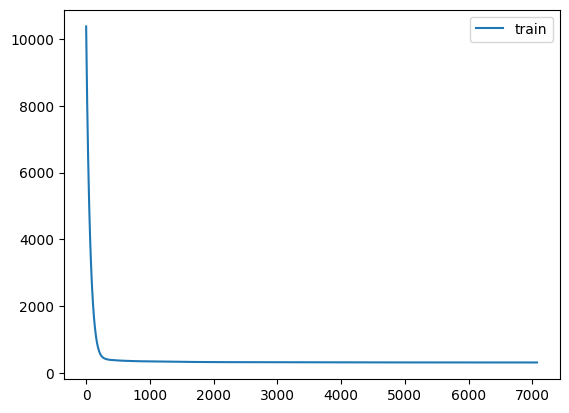

In [40]:
my_model.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], verbose=False)

results = my_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
# plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [41]:
# calculate the rmse on train and test set
from sklearn.metrics import mean_squared_error
from math import sqrt

y_train_pred = my_model.predict(X_train)
y_val_pred = my_model.predict(X_val)
y_test_pred = my_model.predict(X_test)

rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train)
print("RMSE on validation set:", rmse_val)
print("RMSE on test set:", rmse_test)

RMSE on train set: 14.389935652579913
RMSE on validation set: 318.1278025583108
RMSE on test set: 352.77984729592094


In [42]:
# calculate the rmse on live set
live_X = live_df[ctrl_tag+ind_tag]
live_y = live_df[cfg.kpi1.tag1]

live_y_pred = my_model.predict(live_X)
rmse_live = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live)

RMSE on live set: 1318.2753326486074


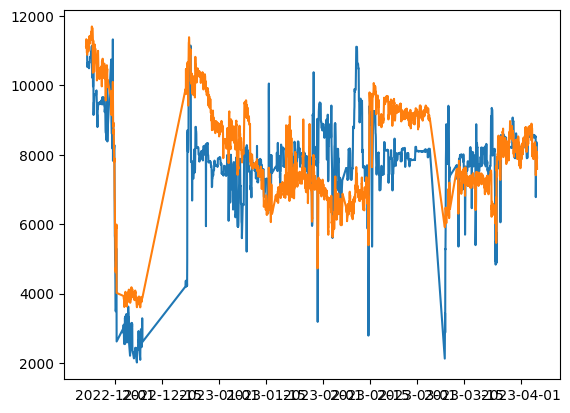

In [43]:
plt.plot(live_X.index, live_y)
plt.plot(live_X.index, live_y_pred)

### Trained on Unshuffled Data

In [44]:
X = df[ctrl_tag+ind_tag]
y = df[cfg.kpi1.tag1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=42)

In [45]:
# my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)

In [46]:
# Define the objective function to be optimized
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
    }

    # Create and train the XGBRegressor with the specified hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-07-21 09:47:03,220] A new study created in memory with name: no-name-130f94aa-3b57-4da1-a126-665c763a7fca
[I 2023-07-21 09:47:14,110] Trial 0 finished with value: 1032.9362417904304 and parameters: {'n_estimators': 3000, 'max_depth': 5, 'learning_rate': 0.08506726057693267, 'subsample': 0.9689243177971072, 'colsample_bytree': 0.9224409867060968, 'min_child_weight': 2, 'reg_alpha': 0.2704149645705809, 'reg_lambda': 0.5312702476316461, 'early_stopping_rounds': 39}. Best is trial 0 with value: 1032.9362417904304.
[I 2023-07-21 09:47:46,265] Trial 1 finished with value: 1048.5385017479123 and parameters: {'n_estimators': 2000, 'max_depth': 2, 'learning_rate': 0.005664764299012921, 'subsample': 0.8829602079954969, 'colsample_bytree': 0.8198966086495192, 'min_child_weight': 10, 'reg_alpha': 0.7300109817064577, 'reg_lambda': 0.1134551231315678, 'early_stopping_rounds': 19}. Best is trial 0 with value: 1032.9362417904304.
[I 2023-07-21 09:48:14,185] Trial 2 finished with value: 1082.27

In [47]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)
my_model = XGBRegressor(**best_params)

Best Hyperparameters: {'n_estimators': 8000, 'max_depth': 6, 'learning_rate': 0.026482327141064937, 'subsample': 0.9296069325486918, 'colsample_bytree': 0.25758221657044433, 'min_child_weight': 8, 'reg_alpha': 0.047088809774299425, 'reg_lambda': 0.061474157252889294, 'early_stopping_rounds': 36}


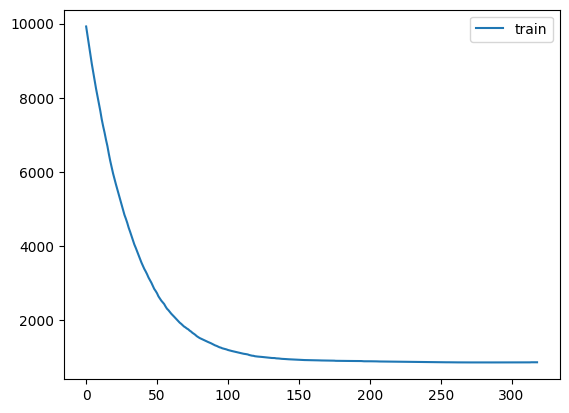

In [48]:
my_model.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], verbose=False)

results = my_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
# plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [49]:
y_train_pred = my_model.predict(X_train)
y_val_pred = my_model.predict(X_val)
y_test_pred = my_model.predict(X_test)

rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train)
print("RMSE on validation set:", rmse_val)
print("RMSE on test set:", rmse_test)

RMSE on train set: 351.3329281043972
RMSE on validation set: 853.4119923990439
RMSE on test set: 1069.7531935634117


In [50]:
# calculate the rmse on live set
live_X = live_df[ctrl_tag+ind_tag]
live_y = live_df[cfg.kpi1.tag1]

live_y_pred = my_model.predict(live_X)
rmse_live = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live)

RMSE on live set: 1316.4682596981718


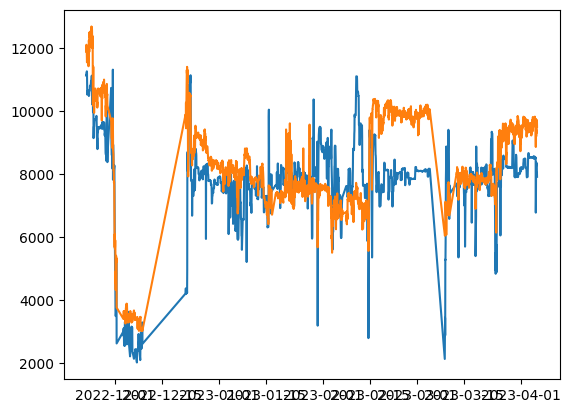

In [51]:
plt.plot(live_X.index, live_y)
plt.plot(live_X.index, live_y_pred)